# SSD
- 运用ssd算法的思想构建一个自己的ssd目标检测模型,自己构建的算法流程图如下所示.
<img src="流程图.png" width="1000" height="1000">

## 1 加载相关库

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torch import nn
from IPython import display
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## 加载相关函数

### 画图函数

In [2]:
def plot_image(num, i, train_loss_his, val_loss_his, train_his_acc, val_his_acc):
    plt.figure(num = num)
    plt.ion()
    plt.cla()
    ax1 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
    ax1.set_xlim((0, num_epochs))
    #ax1.set_ylim(0, 1.6)
    ax1.plot(range(i + 1), train_loss_his, label='train_loss')
    ax1.plot(range(i + 1), val_loss_his, label='val_loss')
    ax1.grid()
    ax1.legend()
    ax2 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
    ax2.set_xlim(0, num_epochs)
    ax2.set_ylim(0, 1)
    ax2.plot(range(i + 1), train_his_acc, label='train_accuracy')
    ax2.plot(range(i + 1), val_his_acc, label='val_accuracy')
    ax2.grid()
    ax2.legend()
    display.clear_output(wait=True)
    plt.pause(0.0000001)
    plt.ioff()
    plt.show()

### 由特征图的大小在原图生成default boxes

In [3]:
def multibox_prior(feature_data, scale, ratio, origin_w = 256, origin_h = 256):
    """
    竖直方向为x,横着方向为y.
    feature_data为输入的数据,每个位置生成锚框,通道数没有用到,批量也没有用到,因为同一批量输入进来的数据的尺寸和通道数都是一样的,
    而此函数是将特征映射图的每个位置映射到原图(锚框中心点不一定是整数),然后按scale和ratio的值生成锚框.所以输入数据在这个计算中
    的锚框只计算一次即可.
    input:
        feature_data:输入的特征映射图
        scale:是缩放比，是得出的锚框面积占原图像的多少
        ratio:宽高比，生成的锚框的宽高比
        origin_w:原图像的宽
        origin_h:原图像的高
    output:
        返回锚框，（批量大小，锚框数量，每个锚框坐标（四个值））,是左上角坐标(x,y)和右下角坐标(x,y).
        同一个位置的锚框是挨着的.每一行代表一个锚框.位置是从左到右,从上到下.是z型的.
        锚框的坐标值都进行了归一化.
    """
    ##输入特征图的高宽
    in_height, in_width = feature_data.shape[-2], feature_data.shape[-1]
    device, num_scale, num_ratio = feature_data.device, len(scale), len(ratio)
    boxes_per_pixel = (num_scale + num_ratio - 1)
    scale_tensor = torch.tensor(scale, device = device)
    ratio_tensor = torch.tensor(ratio, device = device)
    
    #生成所有锚框中心点,因为将原图的长宽都归一化了,所以步长要为1/特征图的高或宽(因为这里的特征图的高宽一样)
    ##先生成特征图的每个像素的中心(加0.5就是为了中心),然后再除以特征图的高宽,将中心点归一化.
    center_x_all = (torch.arange(in_height, device = device) + 0.5) / in_height
    center_y_all = (torch.arange(in_width, device = device) + 0.5) / in_width
    center_x, center_y = torch.meshgrid(center_x_all, center_y_all, indexing = 'ij')
    center_x, center_y = center_x.reshape(-1), center_y.reshape(-1)  #转为一维向量，对应xy构成中心点坐标。
    
    ##生成每个锚框的宽和高，是由缩放比和宽高比计算得到的。
    ##w和h是先scale乘ratio第一个元素，再计算scale第一个元素乘ratio除了第一个元素的其他元素。用torch.cat来合到一维上。这个是无所谓的,
    ##在这里是因为生成少一点的default boxes.
    w = torch.cat((torch.sqrt(scale_tensor * ratio_tensor[0]), torch.sqrt(scale_tensor[0] * ratio_tensor[1:])))
    h = torch.cat((torch.sqrt(scale_tensor / ratio_tensor[0]), torch.sqrt(scale_tensor[0] / ratio_tensor[1:])))
    
    ##宽高除以2来得到宽高的一半，以便通过中心点快速找到每个锚框右上角和右下加.
    ##每个像素有boxes_per_pixel边框，故重复in_height * in_width像素次数。
    anchor_manipulations = torch.stack((-w, -h, w, h), dim = 1).repeat(in_height * in_width, 1) / 2
    
    ##每个中心点有boxes_per_pixel锚框
    ##有in_height * in_width个像素，每个像素有boxes_per_pixel边框。
    out_grid = torch.stack((center_x, center_y, center_x, center_y), dim = 1).repeat_interleave(boxes_per_pixel, dim=0)
    ##得到每个像素的boxes_per_pixel个锚框
    output = (out_grid + anchor_manipulations).unsqueeze(0)
    
    return output

In [4]:
x = torch.rand((1, 3 ,3, 3))
y = multibox_prior(x, scale = [0.75, 0.5, 0.25], ratio = [1, 2, 0.5])
y.shape, y

(torch.Size([1, 45, 4]),
 tensor([[[-0.2663, -0.2663,  0.5997,  0.5997],
          [-0.1869, -0.1869,  0.5202,  0.5202],
          [-0.0833, -0.0833,  0.4167,  0.4167],
          [-0.4457, -0.1395,  0.7790,  0.4729],
          [-0.1395, -0.4457,  0.4729,  0.7790],
          [-0.2663,  0.0670,  0.5997,  0.9330],
          [-0.1869,  0.1464,  0.5202,  0.8536],
          [-0.0833,  0.2500,  0.4167,  0.7500],
          [-0.4457,  0.1938,  0.7790,  0.8062],
          [-0.1395, -0.1124,  0.4729,  1.1124],
          [-0.2663,  0.4003,  0.5997,  1.2663],
          [-0.1869,  0.4798,  0.5202,  1.1869],
          [-0.0833,  0.5833,  0.4167,  1.0833],
          [-0.4457,  0.5271,  0.7790,  1.1395],
          [-0.1395,  0.2210,  0.4729,  1.4457],
          [ 0.0670, -0.2663,  0.9330,  0.5997],
          [ 0.1464, -0.1869,  0.8536,  0.5202],
          [ 0.2500, -0.0833,  0.7500,  0.4167],
          [-0.1124, -0.1395,  1.1124,  0.4729],
          [ 0.1938, -0.4457,  0.8062,  0.7790],
          [ 0.0

In [5]:
def box_iou(boxes1, boxes2):
    """
    input:
        boxes1:输入的第一组锚框(n, 4)n是有多少个锚框,4是锚框的左上角和左下角的四个值先x后y.
        boxes2:输入的第二组锚框(n, 4)n是有多少个锚框,4是锚框的左上角和左下角的四个值先x后y.
    output:
        返回n个锚框的交并比.输出的每一行是boxes1的每一个锚框与boxes2的每个锚框的交并比.
    """
    def box_area(boxes):
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        return area
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)
    
    #注意:是boxes1与boxes2中的每个锚框都要计算交并比,并不是只计算对应行的锚框的交并比.这个要进行注意
    #找输入锚框boxes1和boxes2的左上角的最大的坐标,计算交并比.用了广播机制.
    inter_upperleft = torch.max(boxes1[:, :2].unsqueeze(dim = 1), boxes2[:, :2])
    #找输入锚框boxes1和boxes2的右下角的最小坐标.用了广播机制.
    inter_lowerright = torch.min(boxes1[:, 2:].unsqueeze(dim = 1), boxes2[:, 2:])
    #clamp(min = 0)是因为有些锚框是没有相交的,这样算的值都是负的.
    inter = (inter_lowerright - inter_upperleft).clamp(min = 0)
    
    #相交区域
    inter_area = inter[:, :, 0] * inter[:, :, 1]
    #相并区域,union_area行是boxes1的锚框,列是boxes1中每个锚框与boxes2中每个锚框相并区域,用了广播机制.
    union_area = area1.unsqueeze(dim = 1) + area2 - inter_area
    
    return inter_area / union_area

In [6]:
x1, x2 = y[0, 0:3], y[0, 2:5]
box_iou(x1, x2), x1, x2

(tensor([[0.3333, 0.5469, 0.5469],
         [0.5000, 0.5300, 0.5300],
         [1.0000, 0.3333, 0.3333]]),
 tensor([[-0.2663, -0.2663,  0.5997,  0.5997],
         [-0.1869, -0.1869,  0.5202,  0.5202],
         [-0.0833, -0.0833,  0.4167,  0.4167]]),
 tensor([[-0.0833, -0.0833,  0.4167,  0.4167],
         [-0.4457, -0.1395,  0.7790,  0.4729],
         [-0.1395, -0.4457,  0.4729,  0.7790]]))

In [7]:
##(正样本个数,4)4是左上角与右下角坐标, (负样本个数,4)4是左上角与右下角坐标, (正样本个数, 4)4是预测的偏移量.
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold = 0.5):
    """
    将最接近的真实边界框分配给锚框,构建的iou矩阵,每行是每个anchor与每个真实框的iou.先通过阈值分配,再找最值分配(这个更重要),这样可以加快速度.
    input:
        ground_truth:二维张量,真实边界框,是自己标注的边界框.(真实边界框个数,4)是一张输入图片中有几个真实边界框,4是左上角与右下角坐标.
        anchors:二维张量,输入图片在每个特征映射图上生成的所有边界框.是一张图片生成的所以边界框.(锚框个数,4)是一张图片生成的所有边界框,4是左上角与右下角坐标.
        device:数据在gpu还是cpu上
        iou_threshold:每个真实边界框都有锚框后,为了补充正样本,通过阈值找到与真实边界框iou超过阈值的锚框.
    output:
        anchors_bbox_map:一维张量,返回锚框分配给真实框的索引.返回一个一维张量(锚框个数,)值为整数是真实框的索引,-1为没有分配给真实框的锚框
    """
    ##得到输入锚框与真实框的个数.
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    ##计算锚框与真实框的iou,每一行是每一个锚框与所有真实框的iou
    jaccard = box_iou(anchors, ground_truth)
    #print(f"jaccard:{jaccard}")
    ##对于每个锚框，分配的真实边界框的张量,初始值均分配为-1，表示未分配真实边界框，长度为num_anchors,即锚框数量
    ##数据类型是torch.long是因为真实框的个数可能有很多.
    anchors_bbox_map = torch.full((num_anchors, ), -1, dtype = torch.long, device = device)
    ##找到iou矩阵中每一行的最大值与索引
    max_ious, index = torch.max(jaccard, dim = 1)
    #print(f"max_ious:{max_ious} \n index:{index}")
    ##找到锚框大于阈值的锚框的索引
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    ##找到锚框大于阈值时应该分配的真实框索引
    box_j = index[max_ious >= iou_threshold]
    #print(f"anc_i:{anc_i} \n box_j:{box_j}")
    ##先通过阈值分配真实框
    anchors_bbox_map[anc_i] = box_j
    
    ##找最值来分配真实框
    col_replace = torch.full((num_anchors,), -1, dtype = torch.long, device = device)
    row_replace = torch.full((num_gt_boxes,), -1, dtype = torch.long, device = device)
    for _ in range(num_gt_boxes):
        index = torch.argmax(jaccard)
        anc_ind = (index / num_gt_boxes).long()
        GTb_ind = (index % num_gt_boxes).long()
        anchors_bbox_map[anc_ind] = GTb_ind
        jaccard[anc_ind] = row_replace
        jaccard[:, GTb_ind] = col_replace
    
    return anchors_bbox_map

In [10]:
ground_truth = torch.tensor([[10, 10, 20, 20], [15, 15, 30, 30], [20, 20, 40, 40]], device='cpu')
anchors = torch.tensor([[5, 5, 40, 40], [15, 15, 45, 45], [30, 30, 70, 70]], device='cpu')
assign_anchor_to_bbox(ground_truth, anchors, torch.device("cpu"))

tensor([1, 2, 0])

In [11]:
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """
    对锚框偏移量的转换,anchors与assigned_bb的框的个数都是相同的,第几个anchors就对应分配的真实框在第几个assigned_bb
    input:
        anchors:锚框.二维张量,(所有的锚框,4)是一张输入图片所有的锚框,
                4是左上角与右下角坐标.已分配真实框的锚框.
        assigned_bb:二维张量.(锚框个数,4)是一张图片标注的所有真实框,4是左上角与右下角坐标.行值全为0的值对应的行数的锚框没有分配真实边界框
        eps:是防止被除数与除数太小导致除法时出现问题.
    output:
        offset:返回锚框分配给真实框的偏移量.返回一个二维张量(锚框个数, 4)，经过别的函数处理，没有被分配真实框的锚框的四个值才是全为0.
    """
    def box_corner_to_center(boxes):
        x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2
        w = x2 - x1
        h = y2 - y1
        boxes = torch.stack((cx, cy, w, h), dim = -1)
        return boxes
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [12]:
anchors = torch.tensor([[10, 10, 20, 20], [15, 15, 30, 30]])
assigned_bb = torch.tensor([[12, 12, 18, 18], [16, 16, 28, 28]])
offset_boxes(anchors, assigned_bb)

tensor([[ 0.0000,  0.0000, -0.5108, -0.5108],
        [-0.0333, -0.0333, -0.2231, -0.2231]])

In [13]:
def multibox_target(anchors, labels):
    """
    此函数将背景类别的索引设置为零,然后将新类别的整数索引递增1
    input:
        anchors:所有锚框的集合，形状为（batch_size, num_gt_boxes, 4），其中最后一维4代表[x1, y1, x2, y2]。
        labels:包含真实边界框和类别标签的张量，形状为(batch_size, num_gt_boxes, 5)，其中最后一维5代表[class_label, x1, y1, x2, y2]。
    output:
        bbox_offset:包含了为每个锚框标记的四个偏移值。 请注意，负类锚框的偏移量被标记为零。是二维数组
        bbox_mask:掩码（mask）变量，形状为（批量大小，锚框数的四倍）。掩码变量中的元素与每个锚框的4个偏移量一一对应。
                    掩码变量中的零将在计算目标函数之前过滤掉负类偏移量。不是背景则值是1。
        class_labels:标记的锚框的类别，0是背景，原类别数加1。
    """
    ##所有输入的图像的anchor都是一样
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels  = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors, device)
        bbox_mask = (anchors_bbox_map >= 0).float().unsqueeze(1).repeat(1, 4)
        ##将类标签和分配的边界框坐标初始化为零，每个值代表每个锚框。
        class_label = torch.zeros(num_anchors, dtype = torch.long, device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype = torch.float32, device=device)
        ##使用真实边界框来标记锚框的类别。如果一个锚框没有被分配，标记其为背景（值为零）
        ##分配有真实框的锚框的索引
        indices_true  = torch.nonzero(anchors_bbox_map >= 0)
        ##得到锚框所分配的真实框的索引
        bb_idx = anchors_bbox_map[indices_true]
        ##将分配有真实框的锚框的类别标注为真实框的类别数加1，0代表背景。
        """print(label[bb_idx[0]])
        print(anchors[0])"""
        class_label[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:].float()
        #print(assigned_bb)
        ##偏移量转换
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        
        ##放到一起
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_label)
        
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

In [14]:
labels = torch.tensor([
    [[1, 15, 15, 30, 30], [0, 10, 10, 20, 20]],  # 第一个批量的类别标签和边界框
    [[1, 12, 12, 18, 18], [2, 16, 16, 28, 28]]   # 第二个批量的类别标签和边界框
])
# 假设我们有9个锚框
anchors = torch.tensor([
    [10, 10, 20, 20], [15, 15, 30, 30], [20, 20, 40, 40],
    [25, 25, 45, 45], [30, 30, 50, 50], [35, 35, 55, 55],
    [40, 40, 60, 60], [45, 45, 65, 65], [50, 50, 70, 70]
])
multibox_target(anchors, labels)

(tensor([[ 0.0000e+00,  0.0000e+00,  9.5367e-07,  9.5367e-07,  0.0000e+00,
           0.0000e+00,  9.5367e-07,  9.5367e-07, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00],
         [ 0.0000e+00,  0.0000e+00, -5.1082e-01, -5.1082e-01, -3.3333e-02,
          -3.3333e-02, -2.2314e-01, -2.2314e-01, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
          -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
 

## 2 前向传播

### 2.1 基础网络块
- 用的预训练好的ResNet的前6层网络。

In [15]:
net = torchvision.models.resnet18(weights = torchvision.models.ResNet18_Weights.DEFAULT)
base_net = nn.Sequential(*list(net.children())[:6])
base_net

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [16]:
x = torch.ones((2, 3, 256, 256))
for layer in base_net:
    x = layer(x)
    print(layer.__class__.__name__, "output_shape:\t", x.shape)

Conv2d output_shape:	 torch.Size([2, 64, 128, 128])
BatchNorm2d output_shape:	 torch.Size([2, 64, 128, 128])
ReLU output_shape:	 torch.Size([2, 64, 128, 128])
MaxPool2d output_shape:	 torch.Size([2, 64, 64, 64])
Sequential output_shape:	 torch.Size([2, 64, 64, 64])
Sequential output_shape:	 torch.Size([2, 128, 32, 32])


### 2.2 多尺度特征块

In [17]:
def dowm_sample_block(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 3, padding = 1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0))
    
    return nn.Sequential(*blk)

In [18]:
x = torch.ones((2, 128, 8, 8))
for layer in dowm_sample_block(128, 128):
    x = layer(x)
    print(layer.__class__.__name__, "output_shape:\t", x.shape)

Conv2d output_shape:	 torch.Size([2, 128, 8, 8])
BatchNorm2d output_shape:	 torch.Size([2, 128, 8, 8])
ReLU output_shape:	 torch.Size([2, 128, 8, 8])
Conv2d output_shape:	 torch.Size([2, 128, 8, 8])
BatchNorm2d output_shape:	 torch.Size([2, 128, 8, 8])
ReLU output_shape:	 torch.Size([2, 128, 8, 8])
MaxPool2d output_shape:	 torch.Size([2, 128, 4, 4])


### 2.3 完整模型

In [19]:
def get_block(i):
    if i == 0:
        blk = base_net
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1, 1))
    else:
        blk = dowm_sample_block(128, 128)
    
    return blk

### 2.4 类别预测
- SSD是用卷积层进行预测,输出的所有通道的每个位置为预测不同类别的概率.

In [20]:
def cls_predict(num_input, num_anchors, num_classes):
    """
    输出的东西并没有说在特征映射图中每个位置的通道对应的值是同一个边框类别在一块,还是边框一组在一块.这个并不用在意,
    因为这个对应的值是当我们训练的时候训练集中的东西是怎么放的,最后的输出值是怎么放的.
    """
    return nn.Conv2d(in_channels = num_input, out_channels = num_anchors * (num_classes + 1), kernel_size = 3, padding = 1)

### 2.5 边界框预测
- 就是预测边界框的偏移量(offset)

In [21]:
def bbox_predict(num_input, num_anchors):
    """
    输出的东西并没有说在特征映射图中每个位置的通道对应的值是同一个边框类别在一块,还是边框一组在一块.这个并不用在意,
    因为这个对应的值是当我们训练的时候训练集中的东西是怎么放的,最后的输出值是怎么放的.
    """
    return nn.Conv2d(in_channels = num_input, out_channels = num_anchors * 4, kernel_size = 3, padding = 1)

- 为了将数据展平融合

In [22]:
def concat_preds1(preds):
    """
    为了融合数据变为同一个位置的锚框的预测值挨着，相邻位置也挨着，在特征映射图上行与行是z字形连接。
    """
    loca_preds = []
    for i in range(len(preds)):
        loca_preds.append(torch.flatten(preds[i].permute(0, 2, 3, 1), start_dim=1))
    preds = torch.cat(loca_preds, dim = 1)
    
    return preds

### 2.6 前向传播

In [23]:
def blk_forward(X, blk, scale, ratio, cls_predict, bbox_predict):
    """
    输出的是每个块的输出特征映射图,特征映射图对应的锚框,基于特征映射图的类别预测,基于特征映射图的边界框偏移量的预测.
    """
    Y = blk(X)
    anchors = multibox_prior(Y, scale, ratio)
    cls_preds = cls_predict(Y)
    bbox_preds = bbox_predict(Y)
    
    return Y, anchors, cls_preds, bbox_preds

### 2.7 SSD模型

In [24]:
scales = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(scales[0]) + len(ratios[0]) - 1

In [25]:
class TinySSD(nn.Module):
    def __init__(self, num_anchors, num_classes, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        idx_input_channels = [128, 128, 128, 128, 128]
        self.blk_ = get_block(0)
        self.cls_ = cls_predict(idx_input_channels[0], self.num_anchors, self.num_classes)
        self.bbox_ = bbox_predict(idx_input_channels[0], self.num_anchors)
        """for i in range(5): ##是因为整个SSD网络有五部分
            setattr(self, f"blk_{i}", get_block(i))
            setattr(self, f"cls_{i}", cls_predict(idx_input_channels[i], self.num_anchors, self.num_classes))
            setattr(self, f"bbox_{i}", bbox_predict(idx_input_channels[i], self.num_anchors))"""
    
    def forward(self, X):
        self.batch_size = len(X)
        anchors, cls_preds, bbox_preds = [],  [],  []
        """for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(X, getattr(self, f"blk_{i}"), scales[i], ratios[i], 
                                                                     getattr(self, f"cls_{i}"), getattr(self, f"bbox_{i}"))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        ##不用在意形状改变后类别是同一个锚框的预测类别挨着还是同一个类别预测值挨着,
        ##这是因为具体哪种情况是由训练的时候我的训练集的东西是怎么放的.
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)"""
        Y, anchor, cls_pred, bbox_pred = blk_forward(X, self.blk_, scales[0], ratios[0], self.cls_, self.bbox_)
        
        anchors.append(anchor)
        cls_preds.append(cls_pred)
        bbox_preds.append(bbox_pred)
        
        anchors = torch.cat(anchors, dim = 1)
        cls_preds = concat_preds1(cls_preds).reshape(self.batch_size, -1, self.num_classes + 1)
        bbox_preds = concat_preds1(bbox_preds).reshape(self.batch_size, -1, self.num_anchors)
        
        return Y, anchors, cls_preds, bbox_preds

In [38]:
net = TinySSD(num_anchors, 1)

In [27]:
x = torch.ones((2, 3, 256, 256))
Y, anchors, cls_preds, bbox_preds = net(x)
Y.shape, anchors.shape, cls_preds.shape, bbox_preds.shape

(torch.Size([2, 128, 32, 32]),
 torch.Size([1, 4096, 4]),
 torch.Size([2, 4096, 2]),
 torch.Size([2, 4096, 4]))

In [28]:
anchors[0, 0:4], cls_preds[0, 0:8], bbox_preds[0, 0:16]

(tensor([[-0.2080, -0.2080,  0.2392,  0.2392],
         [-0.2451, -0.2451,  0.2764,  0.2764],
         [-0.3006, -0.1425,  0.3319,  0.1737],
         [-0.1425, -0.3006,  0.1737,  0.3319]]),
 tensor([[ 0.5675, -0.1531],
         [-0.4040, -0.3229],
         [ 0.2022, -0.3864],
         [ 0.1109,  0.3222],
         [-0.0512, -0.2267],
         [-0.4944,  0.1246],
         [ 0.3375, -0.1504],
         [ 0.3743,  0.7429]], grad_fn=<SliceBackward0>),
 tensor([[-0.6037, -0.1444,  0.4082, -0.4591],
         [ 0.2632, -0.0634, -0.2583,  0.2985],
         [-0.2412,  0.3440,  0.2798,  0.2658],
         [-0.0413, -0.2419,  0.0119, -0.1481],
         [-0.1401, -0.0223,  0.3051, -0.1466],
         [-0.8708,  0.0743,  0.1341,  0.1062],
         [-0.5684,  0.7054,  0.0756, -0.2449],
         [-0.1126, -0.4281,  0.6010,  0.1057],
         [-0.0811, -0.0665,  0.1183, -0.4917],
         [-0.6865,  0.4111, -0.1646,  0.1088],
         [ 0.1607,  0.2087,  0.4120, -0.1211],
         [-0.3327, -0.2302,  0.28

In [51]:
x, y = all_data[0][0].unsqueeze(0), all_data[0][1]
Y, anchors, cls_preds, bbox_preds = net(x)
assign_anchor_to_bbox(y[1:].unsqueeze(0), anchors, anchors.device)

RuntimeError: The size of tensor a (4) must match the size of tensor b (2) at non-singleton dimension 3

## 3 训练模型

### 3.1 加载香蕉数据集

In [29]:
path_train = "C:/Users/CCU6/Desktop/数据集/banana-detection/banana-detection/bananas_train"
path_validtion = "C:/Users/CCU6/Desktop/数据集/banana-detection/banana-detection/bananas_val"

In [30]:
def read_banana_data(is_train = True, path_train = path_train, path_val = path_validtion):
    if is_train:
        image_path = path_train
        csv_path = path_train + "/label.csv"
        csv_data = pd.read_csv(csv_path)
    else:
        image_path = path_val
        csv_path = path_val + "/label.csv"
        csv_data = pd.read_csv(csv_path)
    images, targets = [], []
    for image_index, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(image_path + "/images/" + target[0]).float())
        target[2:] = target[2:] / 256
        targets.append(list(target[1:]))
    
    return images, torch.tensor(targets)

In [31]:
image, target = read_banana_data()
target[0]

tensor([0.0000, 0.4062, 0.0781, 0.5586, 0.2266])

In [32]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, is_train = True, transforms = None):
        super().__init__()
        self.images, self.labels = read_banana_data(is_train = is_train)
        
    def __getitem__(self, index):
        return self.images[index], self.labels[index]
    
    def __len__(self):
        return len(self.images)

In [33]:
all_data = MyDataset(True)
len(all_data), all_data[0]

(1000,
 (tensor([[[217., 223., 220.,  ...,  28.,  15.,  28.],
           [206., 207., 215.,  ...,  41.,  18.,  29.],
           [191., 197., 210.,  ...,  54.,  28.,  18.],
           ...,
           [205., 211., 207.,  ...,  44.,  50.,  75.],
           [201., 202., 203.,  ...,  50.,  55.,  69.],
           [198., 195., 198.,  ...,  55.,  59.,  68.]],
  
          [[214., 220., 219.,  ...,  23.,  10.,  23.],
           [203., 207., 214.,  ...,  36.,  13.,  24.],
           [191., 197., 210.,  ...,  46.,  23.,  13.],
           ...,
           [202., 208., 204.,  ...,  45.,  52.,  77.],
           [197., 199., 200.,  ...,  52.,  57.,  72.],
           [194., 191., 195.,  ...,  57.,  61.,  71.]],
  
          [[241., 249., 250.,  ...,  19.,   4.,  17.],
           [230., 233., 245.,  ...,  32.,   7.,  18.],
           [215., 223., 238.,  ...,  43.,  17.,   7.],
           ...,
           [221., 225., 221.,  ...,  37.,  39.,  63.],
           [214., 216., 217.,  ...,  41.,  43.,  55.],
  

In [31]:
"""train = torch.utils.data.DataLoader(MyDataset(True), batch_size = 128, shuffle = True, num_workers = 0)
val = torch.utils.data.DataLoader(MyDataset(False), batch_size = 128, shuffle = True, num_workers = 0)"""

'train = torch.utils.data.DataLoader(MyDataset(True), batch_size = 128, shuffle = True, num_workers = 0)\nval = torch.utils.data.DataLoader(MyDataset(False), batch_size = 128, shuffle = True, num_workers = 0)'

### 3.2 定义损失函数

In [32]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks, alpha = 1):
    """
    输入分别是类别预测值,类别真实值,边界框偏移量预测值,边界框偏移量真实值,掩码变量.
    """
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks).mean(dim=1)
    return cls + alpha * bbox

### 3.3 评估标准

In [33]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    return float((cls_preds.argmax(dim=-1).type(cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

### 3.4 训练函数

In [34]:
def train(net, num_epochs, alpha, device, batch_size):
    train_cls_his_acc = []
    val_cls_his_acc = []
    train_bbox_loss_his = []
    val_bbox_loss_his = []
    train = torch.utils.data.DataLoader(MyDataset(True), batch_size = batch_size, shuffle = True, num_workers = 0)
    val = torch.utils.data.DataLoader(MyDataset(False), batch_size = batch_size, shuffle = True, num_workers = 0)
    trainer = torch.optim.SGD(net.parameters(), lr = alpha, weight_decay = 5e-4)
    net = net.to(device)
    print(f"train on: {device}")
    for i in range(num_epochs):
        train_cls_acc = 0
        train_bbox_loss = 0
        net.train()
        for image, target in train:
            trainer.zero_grad()
            X, Y = image.to(device), target.unsqueeze(1).to(device)
            ##边界框，类别预测值(批量,锚框数,类别数带背景)，偏移量预测值(批量,锚框偏移量)
            anchors, cls_preds, bbox_preds = net(X)
            ##锚框与真实框偏移量(批量,锚框个数*4)，掩码(批量,锚框个数*4)，锚框类别(批量,锚框个数)
            bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)
            loss = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
            loss.mean().backward()
            trainer.step()
            with torch.no_grad():
                train_cls_acc = cls_eval(cls_preds, cls_labels) + train_cls_acc
                train_bbox_loss = bbox_eval(bbox_preds, bbox_labels, bbox_masks) + train_bbox_loss
        net.eval()
        with torch.no_grad():
            val_cls_acc = 0
            val_bbox_loss = 0
            for image, target in val:
                X, Y = image.to(device), target.unsqueeze(1).to(device)
                anchors, cls_preds, bbox_preds = net(X)
                bbox_labels, bbox_masks, cls_labels = multibox_target(anchors, Y)
                val_cls_acc = cls_eval(cls_preds, cls_labels) + val_cls_acc
                val_bbox_loss = bbox_eval(bbox_preds, bbox_labels, bbox_masks) + val_bbox_loss
        
        train_cls_his_acc.append(train_cls_acc)
        val_cls_his_acc.append(val_cls_acc)
        train_bbox_loss_his.append(train_bbox_loss)
        val_bbox_loss_his.append(val_bbox_loss)
        plot_image(2, i, train_bbox_loss_his, val_bbox_loss_his, train_cls_his_acc, val_cls_his_acc)
    #print(f"train acc:{max(train_cls_his_acc)}, test acc:{max(val_cls_his_acc)}")

### 3.5 训练

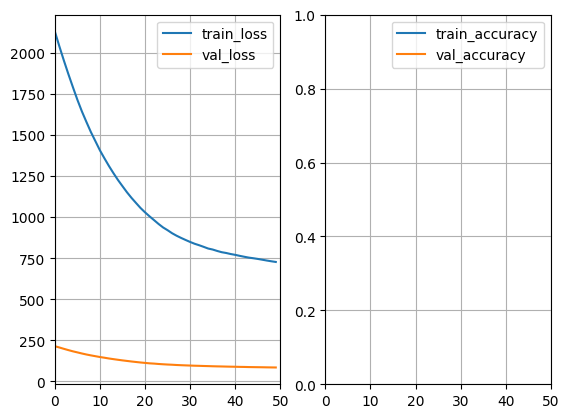

train acc:5443000.0, test acc:544300.0


In [35]:
net = TinySSD(num_anchors, 1)
device = torch.device("cuda:0")
num_epochs, alpha, batch_size = 50, 0.5, 32
train(net, num_epochs, alpha, device, batch_size)

## 4 测试

In [36]:
X, Y = read_banana_data(False)

In [37]:
len(X), X[0].shape, Y.shape, X[0], Y[0]

(100,
 torch.Size([3, 256, 256]),
 torch.Size([100, 5]),
 tensor([[[36., 37., 38.,  ..., 18., 17., 17.],
          [38., 38., 39.,  ..., 18., 18., 18.],
          [38., 39., 40.,  ..., 19., 18., 18.],
          ...,
          [11.,  8.,  8.,  ...,  3.,  2.,  2.],
          [10.,  8.,  7.,  ...,  3.,  2.,  2.],
          [ 8.,  8.,  5.,  ...,  3.,  2.,  2.]],
 
         [[30., 31., 31.,  ..., 21., 20., 20.],
          [32., 32., 32.,  ..., 21., 21., 21.],
          [32., 33., 34.,  ..., 22., 21., 21.],
          ...,
          [ 3.,  3.,  2.,  ...,  3.,  2.,  2.],
          [ 4.,  4.,  3.,  ...,  3.,  2.,  2.],
          [ 4.,  4.,  3.,  ...,  3.,  2.,  2.]],
 
         [[34., 35., 38.,  ..., 26., 25., 25.],
          [36., 36., 39.,  ..., 26., 26., 26.],
          [36., 37., 38.,  ..., 27., 26., 26.],
          ...,
          [ 1.,  0.,  2.,  ...,  3.,  2.,  2.],
          [ 4.,  3.,  4.,  ...,  3.,  2.,  2.],
          [ 3.,  3.,  6.,  ...,  3.,  2.,  2.]]]),
 tensor([0.0000, 0.7148, 